In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns 

#Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Metrics
from sklearn.metrics import accuracy_score

full_data = pd.read_csv('/content/rainfall_data_edited.csv')

In [4]:
full_data.shape

(142193, 24)

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [6]:
#Replace yes/no with 1/0
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

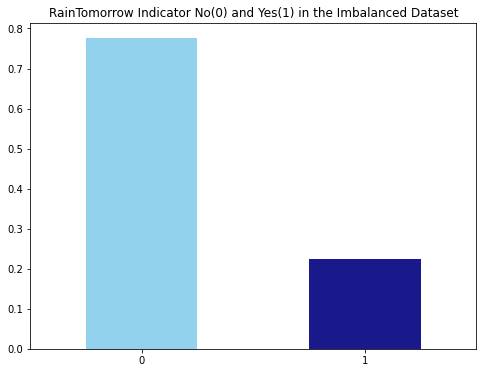

In [7]:
fig = plt.figure(figsize = (8,6))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

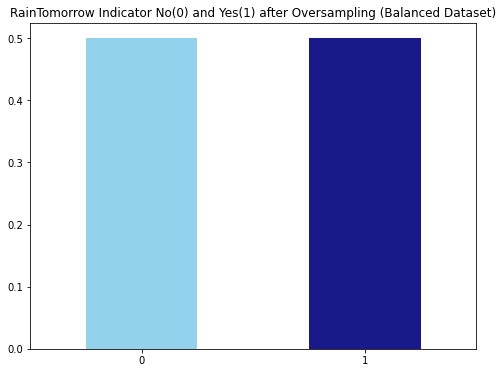

In [8]:
#Make the data set balanced
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,6))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

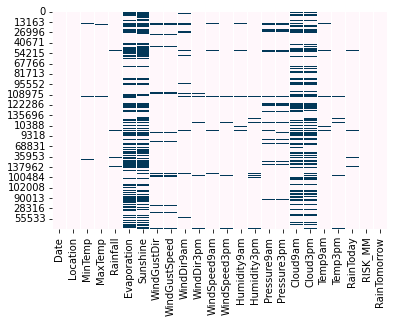

In [9]:
# check the null values in Training Data
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [10]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [11]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [12]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [13]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [14]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [15]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
MiceImputed.shape

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


(220632, 24)

In [16]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

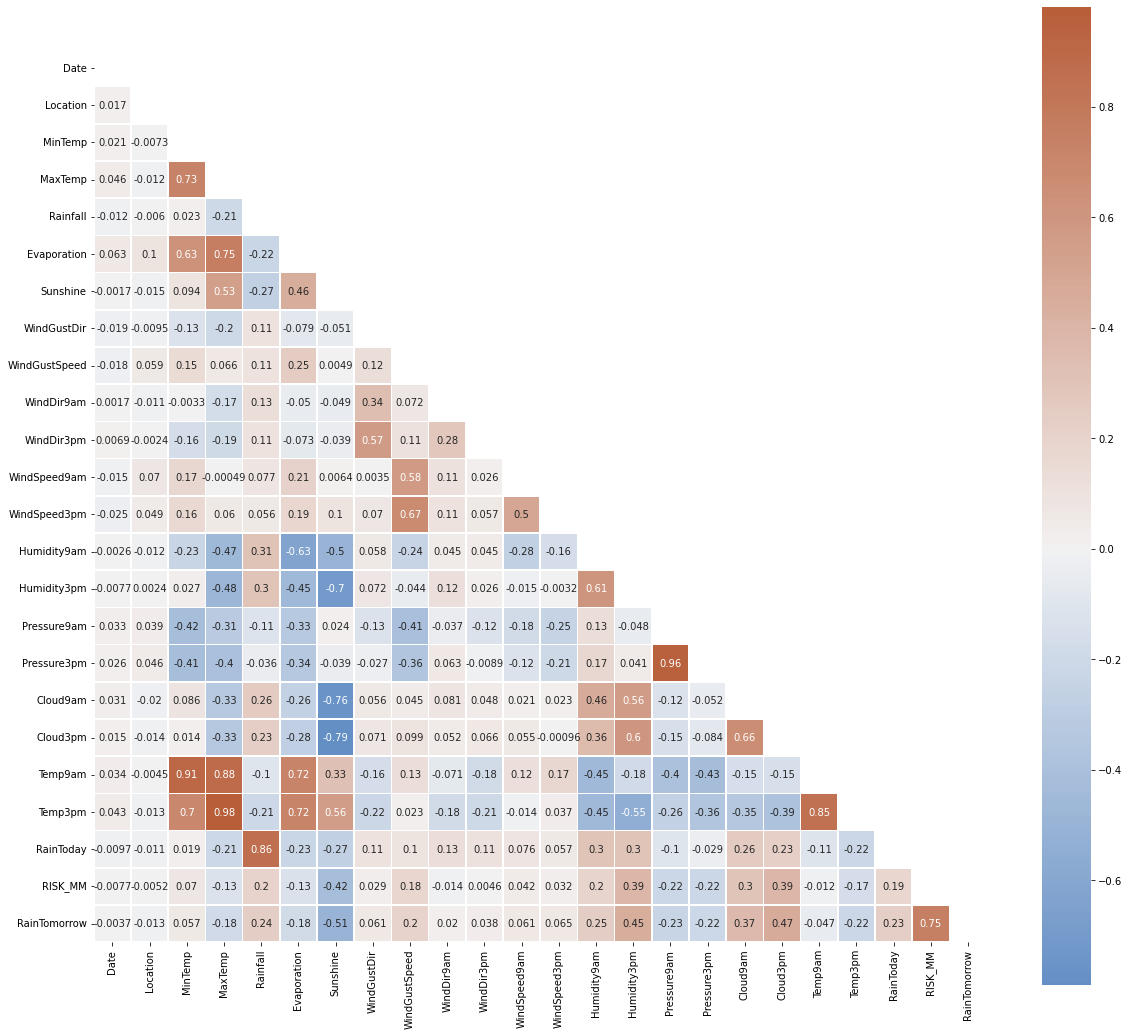

In [17]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [18]:
#Find if there are any duplicates
MiceImputed[MiceImputed.index.duplicated()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
78684,3369.0,44.0,13.4,25.8,0.0,7.400000,5.100000,1.0,28.0,4.0,...,36.0,1026.4,1022.3,3.000000,7.000000,21.3,25.5,0.0,7.2,1.0
42896,1961.0,47.0,11.4,17.1,0.0,2.276564,6.241714,7.0,35.0,15.0,...,82.0,1015.5,1009.6,4.000000,2.000000,14.2,16.5,0.0,5.6,1.0
49205,1857.0,40.0,15.5,30.3,0.0,6.957924,8.782837,14.0,39.0,4.0,...,22.0,1011.7,1007.0,4.079428,3.760652,20.2,29.1,0.0,9.2,1.0
56912,606.0,6.0,4.7,15.1,0.6,1.200000,6.134301,6.0,24.0,14.0,...,73.0,1008.1,1006.6,4.000000,5.000000,10.0,15.0,0.0,2.4,1.0
43920,2995.0,47.0,17.3,24.0,0.0,7.999201,5.161317,9.0,35.0,13.0,...,69.0,1017.3,1016.5,5.134708,5.983722,21.2,21.7,0.0,5.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131715,2254.0,17.0,13.6,26.3,0.0,4.153650,5.775588,7.0,30.0,3.0,...,63.0,1016.5,1013.1,5.799029,5.476615,16.6,25.2,0.0,2.0,1.0
125885,2622.0,43.0,12.1,22.6,0.0,3.580748,6.198887,9.0,28.0,10.0,...,61.0,1020.6,1019.7,5.226307,5.391114,18.3,20.8,0.0,2.0,1.0
130416,950.0,17.0,1.1,11.8,0.4,-1.695532,0.725087,14.0,13.0,3.0,...,98.0,1020.1,1013.3,6.438835,7.620772,4.0,9.5,0.0,8.8,1.0
84962,503.0,8.0,24.8,31.5,0.0,5.400000,3.400000,9.0,48.0,10.0,...,60.0,1008.6,1006.2,5.000000,6.000000,28.7,30.3,0.0,9.8,1.0


In [19]:
#Remove the duplicates
MiceImputed = MiceImputed[~MiceImputed.index.duplicated()]

In [45]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)
modified_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112763 entries, 0 to 128984
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           112763 non-null  float64
 1   Location       112763 non-null  float64
 2   MinTemp        112763 non-null  float64
 3   MaxTemp        112763 non-null  float64
 4   Rainfall       112763 non-null  float64
 5   Evaporation    112763 non-null  float64
 6   Sunshine       112763 non-null  float64
 7   WindGustDir    112763 non-null  float64
 8   WindGustSpeed  112763 non-null  float64
 9   WindDir9am     112763 non-null  float64
 10  WindDir3pm     112763 non-null  float64
 11  WindSpeed9am   112763 non-null  float64
 12  WindSpeed3pm   112763 non-null  float64
 13  Humidity9am    112763 non-null  float64
 14  Humidity3pm    112763 non-null  float64
 15  Pressure9am    112763 non-null  float64
 16  Pressure3pm    112763 non-null  float64
 17  Cloud9am       112763 non-nul

In [21]:
#Checked and can be removed
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'RISK_MM'],
      dtype='object')


In [22]:
#Checked and can be removed
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'RISK_MM']
[0.00255211 0.00255661 0.00314478 0.00393191 0.00756046 0.00292933
 0.04658303 0.00156727 0.00697731 0.00200717 0.00187137 0.00174023
 0.00209923 0.00529036 0.03137565 0.00812301 0.01053396 0.01300182
 0.03019836 0.0030321  0.00503486 0.00278127 0.80510781]


In [23]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
#splitting in 3:7 ratio
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

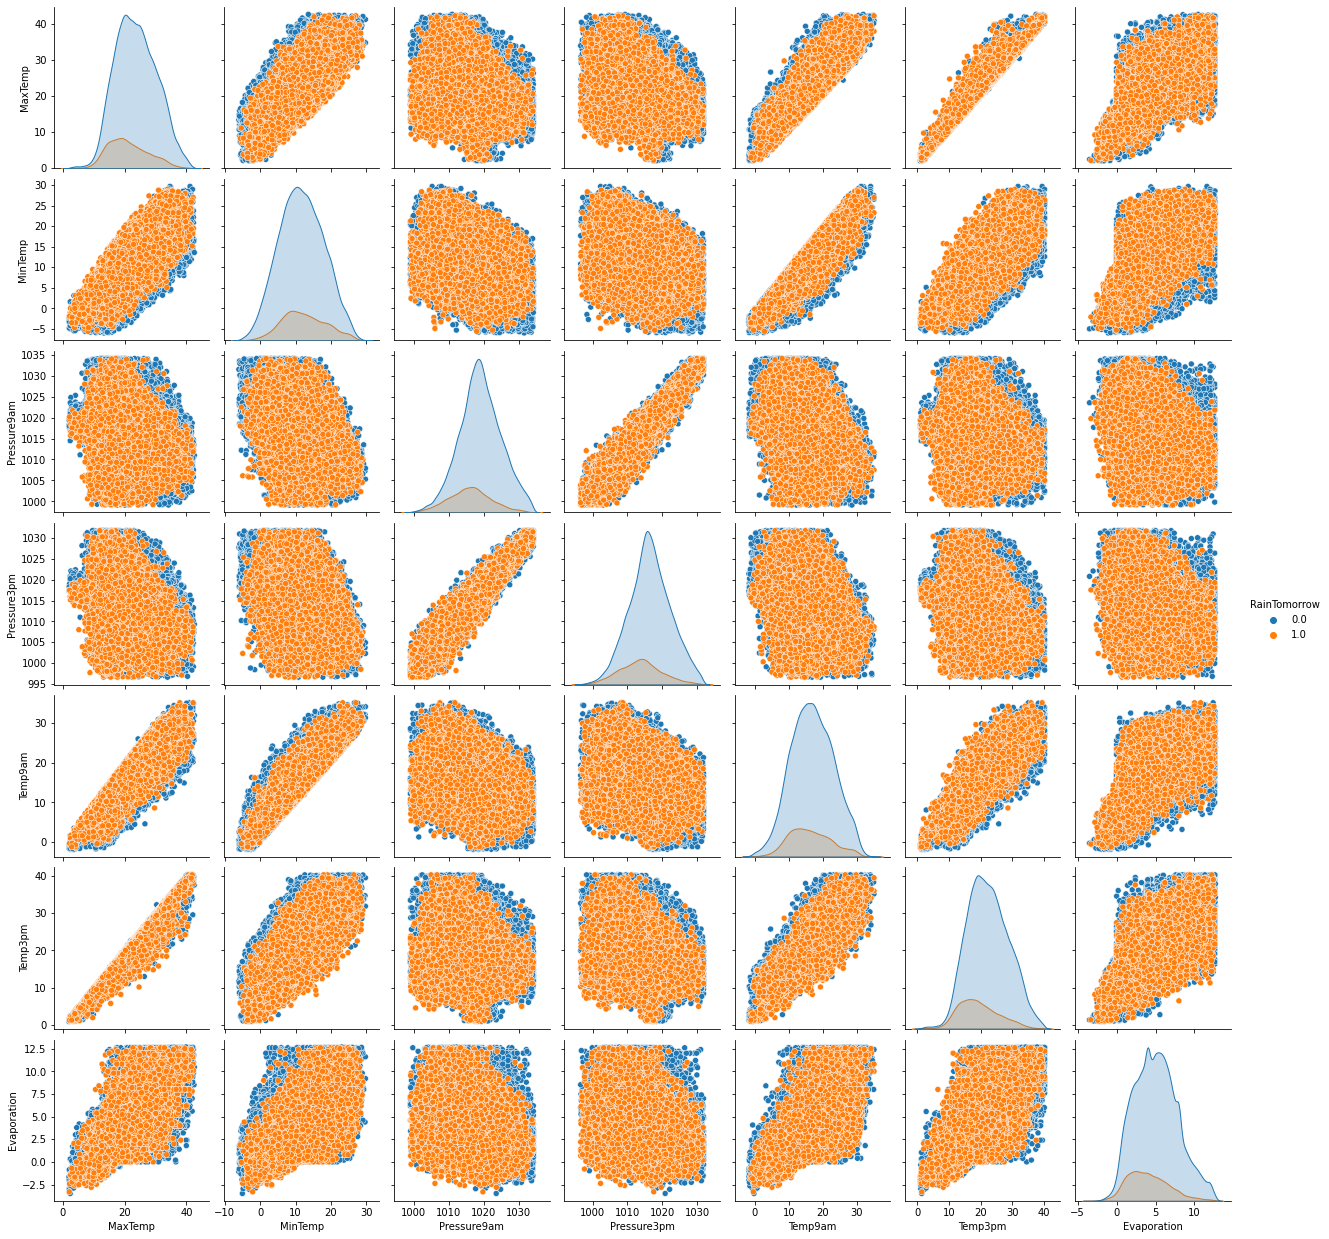

In [24]:
#Finalcheckpoint
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

In [25]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [26]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'RISK_MM'],
      dtype='object')


In [27]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'RISK_MM']
[0.00255211 0.00255661 0.00314478 0.00393191 0.00756046 0.00292933
 0.04658303 0.00156727 0.00697731 0.00200717 0.00187137 0.00174023
 0.00209923 0.00529036 0.03137565 0.00812301 0.01053396 0.01300182
 0.03019836 0.0030321  0.00503486 0.00278127 0.80510781]


In [28]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [29]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [30]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, model_name, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0

    print(f"===== Results for {model_name} model =====")

    print(f"Accuracy =  %.3f" % accuracy)
    print(f"ROC Area under curve  =  %.3f" % roc_auc)
    print(f"Cohen's Kappa  =  %.3f" % coh_kap)
    print(f"Time taken =  %.3f" % time_taken)

    #print("Accuracy = {}".format(accuracy))
    #print("ROC Area under Curve = {}".format(roc_auc))
    #print("Cohen's Kappa = {}".format(coh_kap))
    #print("Time taken = {}".format(time_taken))
    
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

===== Results for Logistic Regression model =====
Accuracy =  0.877
ROC Area under curve  =  0.669
Cohen's Kappa  =  0.414
Time taken =  2.817
              precision    recall  f1-score   support

         0.0    0.89637   0.96708   0.93038     23934
         1.0    0.66737   0.37139   0.47721      4257

    accuracy                        0.87712     28191
   macro avg    0.78187   0.66923   0.70380     28191
weighted avg    0.86179   0.87712   0.86195     28191



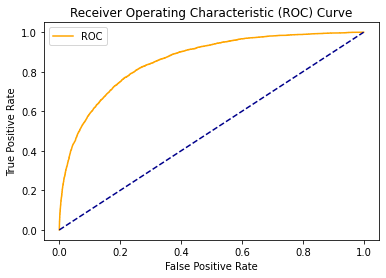

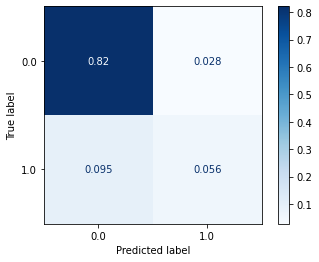

In [31]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test,"Logistic Regression")


===== Results for Decision Tree model =====
Accuracy =  0.849
ROC Area under curve  =  0.684
Cohen's Kappa  =  0.385
Time taken =  0.427
              precision    recall  f1-score   support

         0.0    0.90367   0.92032   0.91192     23934
         1.0    0.50026   0.44844   0.47293      4257

    accuracy                        0.84907     28191
   macro avg    0.70197   0.68438   0.69243     28191
weighted avg    0.84275   0.84907   0.84563     28191



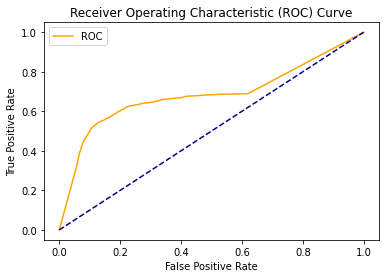

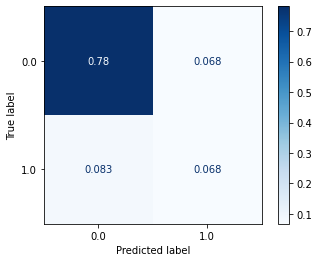

In [32]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test,"Decision Tree")

===== Results for Random Forest model =====
Accuracy =  0.896
ROC Area under curve  =  0.701
Cohen's Kappa  =  0.497
Time taken =  23.009
              precision    recall  f1-score   support

         0.0    0.90496   0.98028   0.94112     23934
         1.0    0.79161   0.42119   0.54983      4257

    accuracy                        0.89585     28191
   macro avg    0.84829   0.70073   0.74547     28191
weighted avg    0.88784   0.89585   0.88203     28191



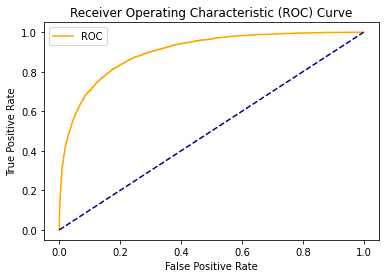

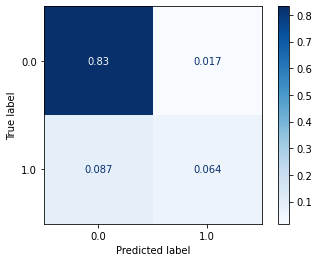

In [33]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test,"Random Forest")

===== Results for Neural Network model =====
Accuracy =  0.925
ROC Area under curve  =  0.809
Cohen's Kappa  =  0.680
Time taken =  267.166
              precision    recall  f1-score   support

         0.0    0.93864   0.97589   0.95690     23934
         1.0    0.82552   0.64130   0.72184      4257

    accuracy                        0.92537     28191
   macro avg    0.88208   0.80859   0.83937     28191
weighted avg    0.92155   0.92537   0.92141     28191



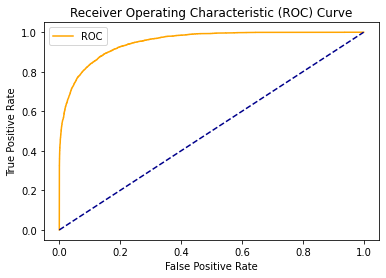

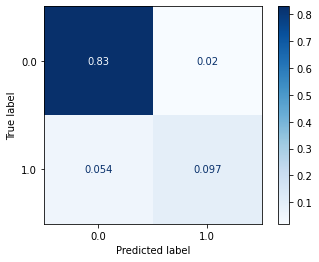

In [34]:
# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test,"Neural Network")


===== Results for Light GBM model =====
Accuracy =  0.902
ROC Area under curve  =  0.770
Cohen's Kappa  =  0.585
Time taken =  4.871
              precision    recall  f1-score   support

         0.0    0.92790   0.95876   0.94308     23934
         1.0    0.71482   0.58116   0.64110      4257

    accuracy                        0.90174     28191
   macro avg    0.82136   0.76996   0.79209     28191
weighted avg    0.89573   0.90174   0.89748     28191



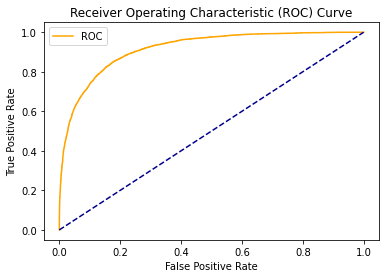

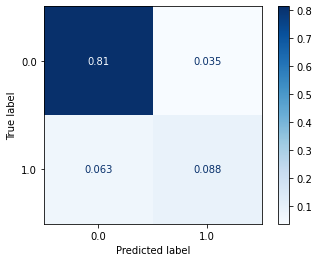

In [35]:
# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test,"Light GBM")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 23 kB/s 
===== Results for Catboost model =====
Accuracy =  0.893
ROC Area under curve  =  0.731
Cohen's Kappa  =  0.525
Time taken =  337.625
              precision    recall  f1-score   support

         0.0    0.91549   0.96231   0.93832     23934
         1.0    0.70260   0.50059   0.58464      4257

    accuracy                        0.89259     28191
   macro avg    0.80905   0.73145   0.76148     28191
weighted avg    0.88335   0.89259   0.88491     28191



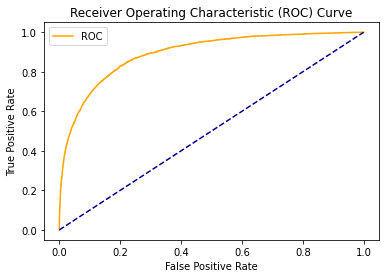

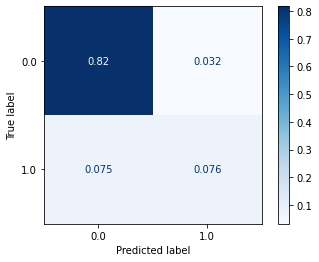

In [36]:
# Catboost
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, "Catboost",verbose=False)

===== Results for XGBoost model =====
Accuracy =  0.910
ROC Area under curve  =  0.763
Cohen's Kappa  =  0.600
Time taken =  282.386
              precision    recall  f1-score   support

         0.0    0.92422   0.97430   0.94860     23934
         1.0    0.79223   0.55086   0.64985      4257

    accuracy                        0.91036     28191
   macro avg    0.85822   0.76258   0.79923     28191
weighted avg    0.90429   0.91036   0.90349     28191



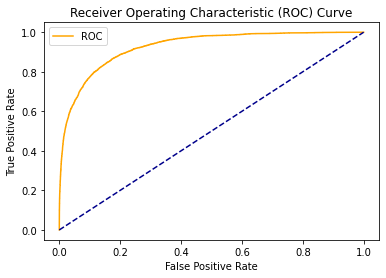

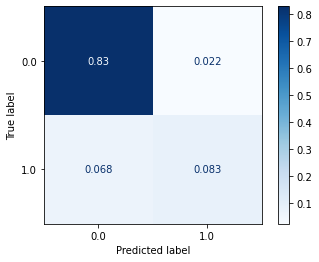

In [37]:
# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test,"XGBoost")

In [38]:
pip install six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


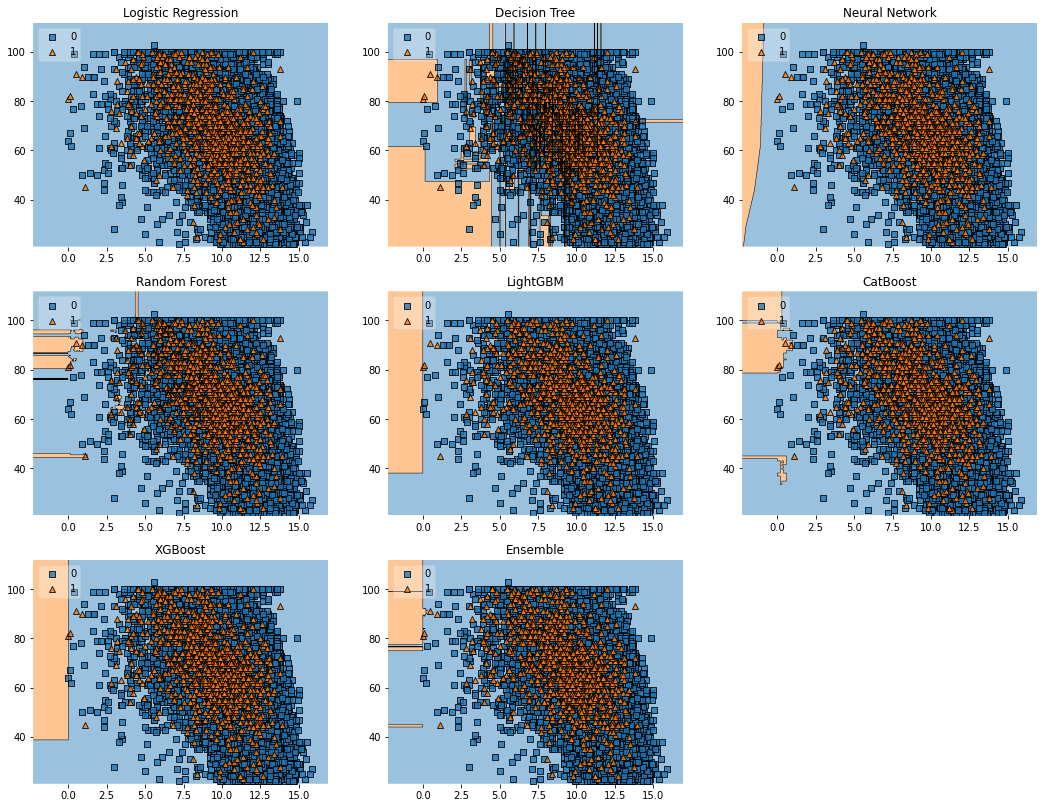

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

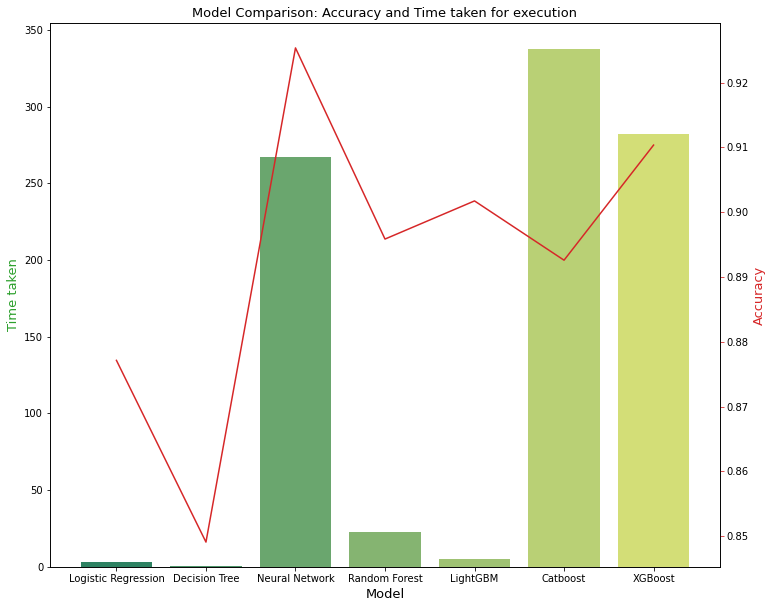

In [40]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

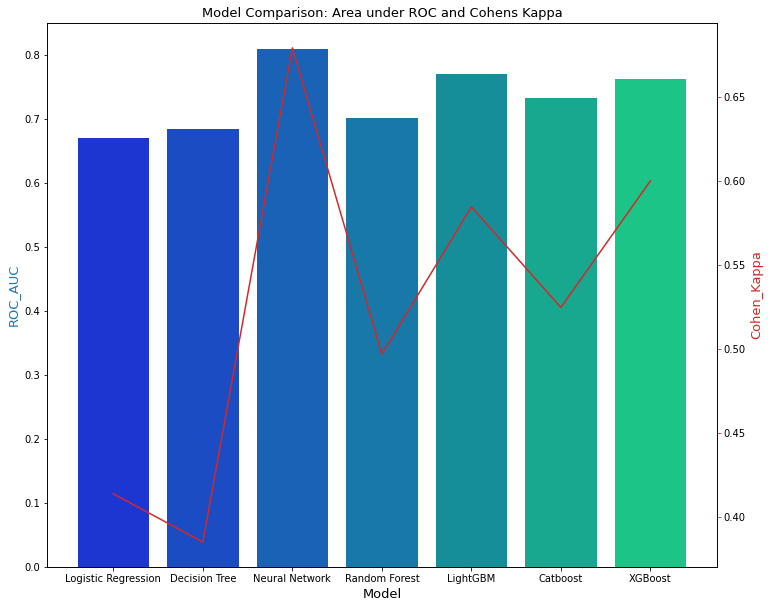

In [41]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()